In [ ]:
!pip install --quiet opencv-python-headless pyarrow


In [ ]:
pip install kaggle

In [1]:
import os, glob, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import cv2

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Paths (adjust as needed)
DATA_DIR = Path("/kaggle/input/dataset/cholec80")     # videos + annotations
WORK_DIR = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [2]:
import os
from pathlib import Path
import pandas as pd

BASE_DIR   = Path("/kaggle/input/dataset/cholec80")
PHASE_DIR  = BASE_DIR / "phase_annotations"
TOOL_DIR   = BASE_DIR / "tool_annotations"

def load_phase_file(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=r"\s+|,|\t", engine="python")
    df.columns = ["Frame", "Phase"]
    return df

def load_tool_file(path: Path) -> pd.DataFrame:
    return pd.read_csv(path, sep=r"\s+|,|\t", engine="python")

def load_video_annotations(vid: str) -> pd.DataFrame:
    phase_path = PHASE_DIR / f"{vid}-phase.txt"
    tool_path  = TOOL_DIR / f"{vid}-tool.txt"
    if not phase_path.exists() or not tool_path.exists():
        print(f"⚠️ Missing {vid}")
        return None
    df_phase = load_phase_file(phase_path)
    df_tool  = load_tool_file(tool_path)
    df = pd.merge(df_phase, df_tool, on="Frame", how="outer").sort_values("Frame")
    df = df.ffill()
    df["Video"] = vid
    return df

videos = [f"video{str(i).zfill(2)}" for i in range(1,16)]
ann_dfs = [load_video_annotations(v) for v in videos if load_video_annotations(v) is not None]
df_all = pd.concat(ann_dfs, ignore_index=True)

# Features
tool_cols = ["Grasper","Bipolar","Hook","Scissors","Clipper","Irrigator","SpecimenBag"]
df_all["ActiveToolCount"] = df_all[tool_cols].sum(axis=1)
phase_map = {p:i for i,p in enumerate(df_all["Phase"].unique())}
df_all["PhaseID"] = df_all["Phase"].map(phase_map)

print("✅ Data shape:", df_all.shape)
print("Phases:", phase_map)
df_all.head()


✅ Data shape: (900091, 12)
Phases: {'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4, 'CleaningCoagulation': 5, 'GallbladderRetraction': 6}


,Frame,Phase,Grasper,Bipolar,Hook,Scissors,Clipper,Irrigator,SpecimenBag,Video,ActiveToolCount,PhaseID
0,0,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0
1,1,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0
2,2,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0
3,3,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0
4,4,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0


In [3]:
import numpy as np

allowed_tools = {
    "Preparation": ["Grasper", "Hook"],
    "CalotTriangleDissection": ["Grasper", "Hook", "Scissors"],
    "ClippingCutting": ["Grasper", "Clipper"],
    "GallbladderDissection": ["Grasper", "Hook", "Scissors"],
    "GallbladderPackaging": ["Grasper", "SpecimenBag"],
    "CleaningCoagulation": ["Grasper", "Irrigator", "Bipolar"],
    "GallbladderRetraction": ["Grasper"]
}

# Required tools for critical phases
required_tools = {
    "ClippingCutting": ["Clipper"],
    "GallbladderPackaging": ["SpecimenBag"]
}

# Max duration (frames @ 25 fps)
max_expected_duration = {
    "Preparation": 5*60*25,
    "CalotTriangleDissection": 20*60*25,
    "ClippingCutting": 5*60*25,
    "GallbladderDissection": 20*60*25,
    "GallbladderPackaging": 5*60*25,
    "CleaningCoagulation": 10*60*25,
    "GallbladderRetraction": 5*60*25,
}

# Forbidden combos
forbidden_combos = [("Clipper", "Scissors")]

def apply_rules(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["error_now"] = 0
    
    # Track phase duration
    df["PhaseChange"] = (df["Phase"] != df["Phase"].shift()).astype(int)
    df["PhaseRun"] = df.groupby(df["Video"]).PhaseChange.cumsum()
    df["TimeInPhase"] = df.groupby(["Video","PhaseRun"]).cumcount()
    
    # Track tool switches
    df["ToolVec"] = df[["Grasper","Bipolar","Hook","Scissors","Clipper","Irrigator","SpecimenBag"]].values.tolist()
    df["ToolSwitch"] = df["ToolVec"].ne(df["ToolVec"].shift()).astype(int)
    df["ToolSwitches_5s"] = df["ToolSwitch"].rolling(window=125, min_periods=1).sum()
    
    # Apply rules (row-wise)
    for idx, row in df.iterrows():
        phase = row["Phase"]
        
        # Rule 1: Tool–phase mismatch
        for tool in tool_cols:
            if row[tool] == 1 and tool not in allowed_tools.get(phase, []):
                df.at[idx, "error_now"] = 1
        
        # Rule 2: Too many tools
        if row["ActiveToolCount"] > 2:
            df.at[idx, "error_now"] = 1

        # Rule 3: Required tool missing
        if phase in required_tools:
            for req in required_tools[phase]:
                if row[req] == 0:
                    df.at[idx, "error_now"] = 1

        # Rule 4: Prolonged inactivity
        if row["ActiveToolCount"] == 0:
            prev_active = df.loc[:idx, "ActiveToolCount"].iloc[::-1].ne(0).idxmax()
            if idx - prev_active > 30*25:
                df.at[idx, "error_now"] = 1

        # Rule 5: Abrupt tool switches
        if row["ToolSwitches_5s"] > 3:
            df.at[idx, "error_now"] = 1

        # Rule 6: Phase overrun
        if row["TimeInPhase"] > max_expected_duration.get(phase, 999999):
            df.at[idx, "error_now"] = 1

        # Rule 7: Forbidden combos
        for t1, t2 in forbidden_combos:
            if row[t1] == 1 and row[t2] == 1:
                df.at[idx, "error_now"] = 1

        # Rule 8: Tool appears too early
        if row["SpecimenBag"] == 1 and phase not in ["GallbladderPackaging","GallbladderRetraction"]:
            df.at[idx, "error_now"] = 1
    
    return df

df_rules = apply_rules(df_all)
print("✅ Errors flagged:", df_rules["error_now"].sum())
df_rules.head()


✅ Errors flagged: 305377


,Frame,Phase,Grasper,Bipolar,Hook,Scissors,Clipper,Irrigator,SpecimenBag,Video,ActiveToolCount,PhaseID,error_now,PhaseChange,PhaseRun,TimeInPhase,ToolVec,ToolSwitch,ToolSwitches_5s
0,0,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0,0,1,1,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,1.0
1,1,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0,0,0,1,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1.0
2,2,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0,0,0,1,2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1.0
3,3,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0,0,0,1,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1.0
4,4,Preparation,1.0,0.0,0.0,0.0,0.0,0.0,0.0,video01,1.0,0,0,0,1,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1.0


In [4]:

import pandas as pd
def generate_hazard_labels(df: pd.DataFrame, fps: int = 25) -> pd.DataFrame:
    df = df.copy()
    df["HazardNow"] = (df["error_now"]
                       .rolling(window=2*fps, min_periods=1)
                       .max())
    df["y_10s"] = df["HazardNow"].shift(-10*fps).fillna(0).astype(int)
    df["y_20s"] = df["HazardNow"].shift(-20*fps).fillna(0).astype(int)
    df["y_30s"] = df["HazardNow"].shift(-30*fps).fillna(0).astype(int)
    return df

df_labels = generate_hazard_labels(df_rules, fps=25)
print(df_labels[["Frame","Phase","error_now","HazardNow","y_10s","y_20s","y_30s"]].head(30))


    Frame        Phase  error_now  HazardNow  y_10s  y_20s  y_30s
0       0  Preparation          0        0.0      0      0      0
1       1  Preparation          0        0.0      0      0      0
2       2  Preparation          0        0.0      0      0      0
3       3  Preparation          0        0.0      0      0      0
4       4  Preparation          0        0.0      0      0      0
5       5  Preparation          0        0.0      0      0      0
6       6  Preparation          0        0.0      0      0      0
7       7  Preparation          0        0.0      0      0      0
8       8  Preparation          0        0.0      0      0      0
9       9  Preparation          0        0.0      0      0      0
10     10  Preparation          0        0.0      0      0      0
11     11  Preparation          0        0.0      0      0      0
12     12  Preparation          0        0.0      0      0      0
13     13  Preparation          0        0.0      0      0      0
14     14 

In [5]:
sample = df_labels.sample(50).sort_values("Frame")
print(sample[["Frame","Phase","error_now","HazardNow","y_10s","y_20s","y_30s"]])


        Frame                    Phase  error_now  HazardNow  y_10s  y_20s  \
298100     46              Preparation          0        0.0      0      0   
781884    472  CalotTriangleDissection          0        0.0      0      0   
526203   1796              Preparation          1        1.0      0      0   
564903   2520  CalotTriangleDissection          0        0.0      0      0   
414164   3683  CalotTriangleDissection          0        0.0      0      0   
635221   5287  CalotTriangleDissection          0        0.0      0      0   
49332    6006              Preparation          0        0.0      0      0   
812073   6135  CalotTriangleDissection          0        0.0      1      0   
764877  10716  CalotTriangleDissection          0        0.0      0      0   
766089  11928  CalotTriangleDissection          0        0.0      0      0   
540749  16342  CalotTriangleDissection          0        0.0      0      0   
61979   18653  CalotTriangleDissection          0        0.0    

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class SurgeryDataset(Dataset):
    def __init__(self, df, window_size=3000, fps=25, features=None, targets=None):
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.fps = fps
        self.features = features or ["PhaseID"] + tool_cols + ["ActiveToolCount"]
        self.targets = targets or ["y_10s","y_20s","y_30s"]

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        X = self.df.loc[idx:idx+self.window_size-1, self.features].astype(float).values
        y = self.df.loc[idx+self.window_size-1, self.targets].astype(float).values
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Example usage
features = ["PhaseID"] + tool_cols + ["ActiveToolCount"]
targets = ["y_10s","y_20s","y_30s"]

dataset = SurgeryDataset(df_labels, window_size=3000, features=features, targets=targets)
X, y = dataset[0]
print("X:", X.shape, "y:", y)


X: torch.Size([3000, 9]) y: tensor([0., 0., 0.])


Device: cuda
pos_weight per horizon: [1.7777463 1.7720305 1.7748854]

=== Epoch 1/5 ===


Train Loss=0.6193, Val Loss=0.6756
[10s] AUROC=0.917 AUPRC=0.887 F1=0.775 P=0.758 R=0.793 thr=0.80 Pos=9768
[20s] AUROC=0.899 AUPRC=0.866 F1=0.757 P=0.724 R=0.793 thr=0.79 Pos=9771
[30s] AUROC=0.886 AUPRC=0.849 F1=0.746 P=0.730 R=0.762 thr=0.77 Pos=9758


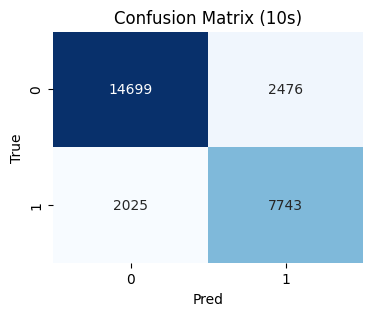

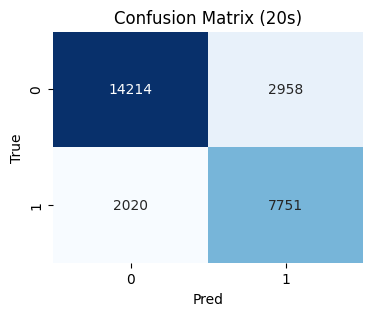

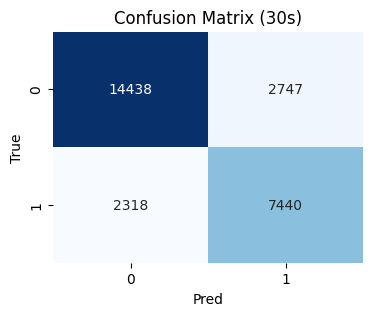


=== Epoch 2/5 ===


Train Loss=0.5494, Val Loss=0.5595
[10s] AUROC=0.920 AUPRC=0.888 F1=0.788 P=0.750 R=0.830 thr=0.65 Pos=9768
[20s] AUROC=0.908 AUPRC=0.876 F1=0.774 P=0.745 R=0.806 thr=0.69 Pos=9771
[30s] AUROC=0.900 AUPRC=0.868 F1=0.760 P=0.739 R=0.782 thr=0.71 Pos=9758


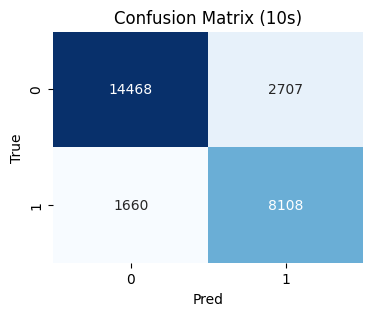

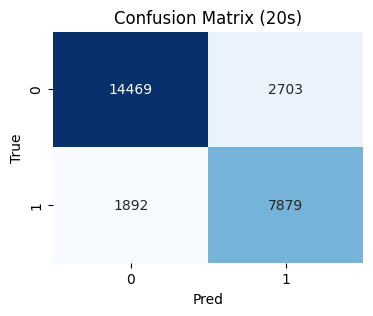

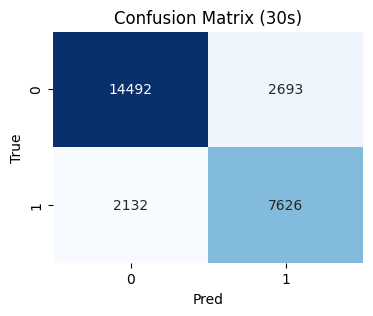


=== Epoch 3/5 ===


Train Loss=0.5262, Val Loss=0.5384
[10s] AUROC=0.935 AUPRC=0.910 F1=0.816 P=0.809 R=0.823 thr=0.71 Pos=9768
[20s] AUROC=0.921 AUPRC=0.896 F1=0.807 P=0.806 R=0.807 thr=0.74 Pos=9771
[30s] AUROC=0.914 AUPRC=0.883 F1=0.790 P=0.755 R=0.828 thr=0.74 Pos=9758


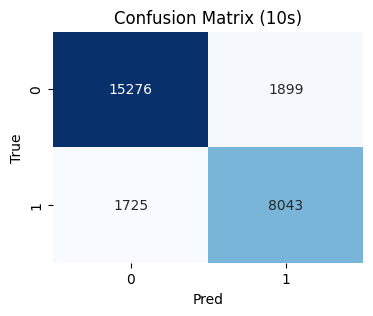

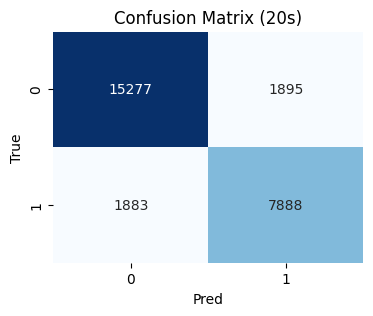

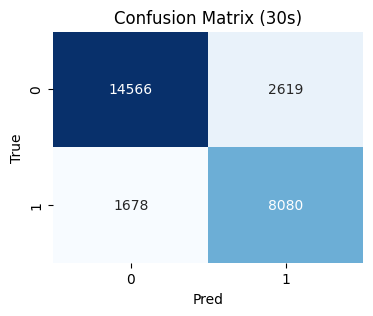


=== Epoch 4/5 ===


Train Loss=0.5121, Val Loss=0.5197
[10s] AUROC=0.937 AUPRC=0.911 F1=0.816 P=0.804 R=0.829 thr=0.67 Pos=9768
[20s] AUROC=0.921 AUPRC=0.896 F1=0.803 P=0.805 R=0.801 thr=0.72 Pos=9771
[30s] AUROC=0.919 AUPRC=0.891 F1=0.798 P=0.797 R=0.800 thr=0.75 Pos=9758


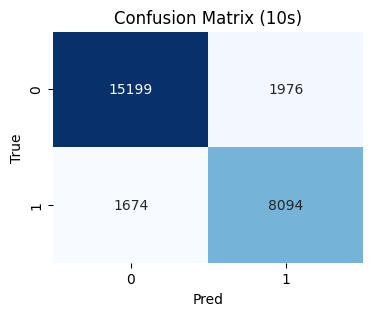

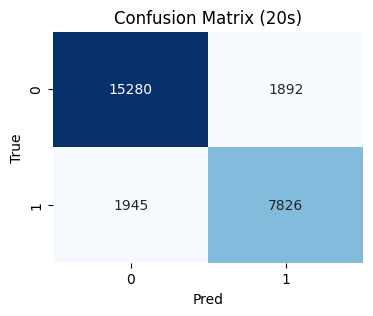

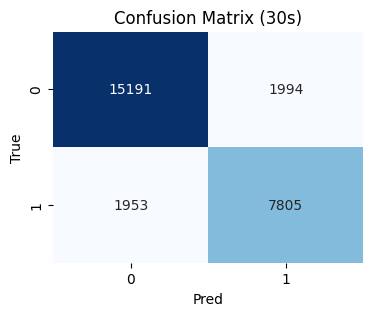


=== Epoch 5/5 ===


Train Loss=0.5070, Val Loss=0.5276
[10s] AUROC=0.940 AUPRC=0.915 F1=0.824 P=0.817 R=0.831 thr=0.79 Pos=9768
[20s] AUROC=0.926 AUPRC=0.899 F1=0.810 P=0.796 R=0.824 thr=0.74 Pos=9771
[30s] AUROC=0.915 AUPRC=0.888 F1=0.796 P=0.784 R=0.809 thr=0.71 Pos=9758


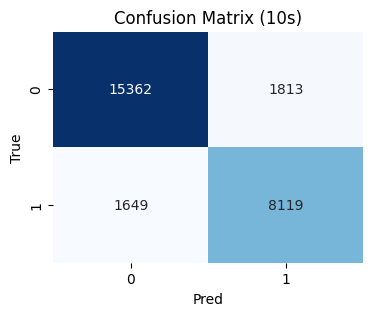

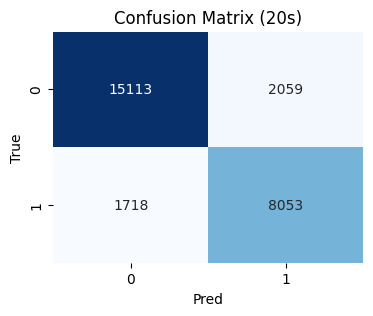

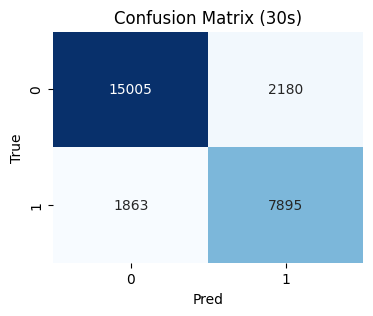

✅ Loaded best model


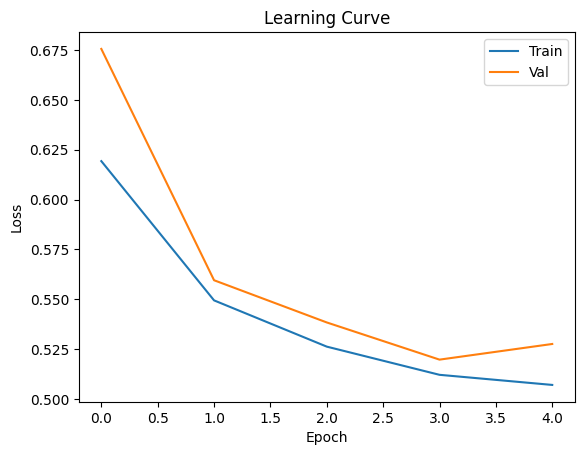

In [7]:
 
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np, pandas as pd, random
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, 
    confusion_matrix, classification_report, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        try:
            torch.cuda.manual_seed_all(seed)
        except Exception as e:
            print("CUDA seed issue:", e)

set_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


 
class SurgeryDataset(Dataset):
    def __init__(self, df, window_size=300, features=None, targets=None):
        self.features = features or [
            "PhaseID","Grasper","Bipolar","Hook","Scissors",
            "Clipper","Irrigator","SpecimenBag","ActiveToolCount"
        ]
        self.targets = targets or ["y_10s","y_20s","y_30s"]

        keep_cols = self.features + self.targets + ["Frame"]
        self.df = df[keep_cols].copy().reset_index(drop=True)

        # sanitize
        self.df[self.features] = self.df[self.features].apply(pd.to_numeric, errors="coerce").fillna(0)
        self.df[self.targets] = self.df[self.targets].apply(pd.to_numeric, errors="coerce").clip(0,1).fillna(0)

        self.window_size = window_size

    def __len__(self):
        return max(0, len(self.df) - self.window_size)

    def __getitem__(self, idx):
        X = self.df.loc[idx:idx+self.window_size-1, self.features].astype(np.float32).values
        y = self.df.loc[idx+self.window_size-1, self.targets].astype(np.float32).values
        return torch.tensor(X), torch.tensor(y)



class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers=num_layers, 
            batch_first=True, dropout=dropout if num_layers>1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        h, _ = self.gru(x)        # [B,T,H]
        h_last = h[:, -1, :]      # [B,H]
        logits = self.head(h_last)  # [B,3]
        return logits  # raw logits


def compute_pos_weight(loader):
    total = 0
    pos = None
    for _,y in loader:
        y_np = y.numpy()
        if pos is None:
            pos = y_np.sum(axis=0)
        else:
            pos += y_np.sum(axis=0)
        total += y_np.shape[0]
    neg = total - pos
    pos = np.clip(pos, 1e-6, None)
    return torch.tensor((neg/pos).astype(np.float32))

def build_weighted_sampler(subset, alpha=4.0):
    # Build sampler using subset indices
    y_end = []
    for i in subset.indices:
        row = subset.dataset.df.loc[i + subset.dataset.window_size - 1, ["y_10s","y_20s","y_30s"]]
        y_end.append(row.sum())
    w = 1.0 + alpha * (np.array(y_end) > 0).astype(np.float32)
    return WeightedRandomSampler(weights=torch.tensor(w), num_samples=len(w), replacement=True)

def best_thresholds(y_true, y_prob):
    ths = []
    for i in range(y_true.shape[1]):
        precision, recall, thresh = precision_recall_curve(y_true[:,i], y_prob[:,i])
        f1 = (2*precision*recall)/(precision+recall+1e-9)
        if len(thresh)==0:
            ths.append(0.5)
        else:
            ths.append(float(thresh[np.nanargmax(f1)]))
    return ths

def eval_per_horizon(y_true, y_prob, thresholds):
    out = {}; cms=[]
    for i, name in enumerate(["10s","20s","30s"]):
        th = thresholds[i]
        yb = (y_prob[:,i] >= th).astype(int)
        t = y_true[:,i].astype(int)
        out[name] = {
            "AUROC": roc_auc_score(t, y_prob[:,i]) if t.mean() not in [0,1] else np.nan,
            "AUPRC": average_precision_score(t, y_prob[:,i]) if t.sum()>0 else np.nan,
            "F1": f1_score(t, yb, zero_division=0),
            "Precision": precision_score(t, yb, zero_division=0),
            "Recall": recall_score(t, yb, zero_division=0),
            "Threshold": th,
            "Positives": int(t.sum())
        }
        cms.append(confusion_matrix(t, yb))
    return out, cms

def plot_cm(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues")
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()


features = [
    "PhaseID","Grasper","Bipolar","Hook","Scissors",
    "Clipper","Irrigator","SpecimenBag","ActiveToolCount"
]
targets = ["y_10s","y_20s","y_30s"]

df_sub = df_labels.sample(frac=0.15, random_state=42).sort_values("Frame").reset_index(drop=True)
window = 300
full_ds = SurgeryDataset(df_sub, window_size=window, features=features, targets=targets)

N = len(full_ds)
split = int(0.8*N)
train_ds, val_ds = torch.utils.data.random_split(
    full_ds, [split, N-split], generator=torch.Generator().manual_seed(42)
)

# Sampler + pos_weight computed from subset
sampler = build_weighted_sampler(train_ds, alpha=6.0)
train_loader_plain = DataLoader(train_ds, batch_size=16, shuffle=False)
pos_weight = compute_pos_weight(train_loader_plain).to(DEVICE)
print("pos_weight per horizon:", pos_weight.cpu().numpy())

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


model = GRUModel(
    input_dim=len(features), hidden_dim=96, num_layers=2, 
    output_dim=len(targets), dropout=0.3
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

history = {"train":[], "val":[]}

def run_eval(loader):
    model.eval()
    ys=[]; ps=[]
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(DEVICE), y.to(DEVICE)
            logits = model(X)
            prob = torch.sigmoid(logits)
            ys.append(y.cpu().numpy())
            ps.append(prob.cpu().numpy())
    if not ys:
        return None
    return np.vstack(ys), np.vstack(ps)

best_val=np.inf; bad=0; patience=3

for epoch in range(1,6):
    print(f"\n=== Epoch {epoch}/5 ===")
    model.train(); tot=0
    for X,y in tqdm(train_loader, desc="Training", leave=False):
        X,y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tot += loss.item()

    train_loss = tot/len(train_loader)

    # val
    ev = run_eval(val_loader)
    if ev is None: break
    y_true,y_prob = ev
    val_loss = 0
    with torch.no_grad():
        for Xv,yv in val_loader:
            Xv,yv = Xv.to(DEVICE), yv.to(DEVICE)
            val_loss += criterion(model(Xv), yv).item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    history["train"].append(train_loss)
    history["val"].append(val_loss)
    print(f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    ths = best_thresholds(y_true,y_prob)
    per_hz,cms = eval_per_horizon(y_true,y_prob,ths)
    for k,v in per_hz.items():
        print(f"[{k}] AUROC={v['AUROC']:.3f} AUPRC={v['AUPRC']:.3f} "
              f"F1={v['F1']:.3f} P={v['Precision']:.3f} R={v['Recall']:.3f} "
              f"thr={v['Threshold']:.2f} Pos={v['Positives']}")
    for i,name in enumerate(["10s","20s","30s"]):
        plot_cm(cms[i], f"Confusion Matrix ({name})")

    if val_loss < best_val-1e-4:
        best_val=val_loss; bad=0
        best_state={k:v.cpu() for k,v in model.state_dict().items()}
    else:
        bad+=1
    if bad>=patience:
        print("Early stopping.")
        break

if 'best_state' in locals():
    model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    print("✅ Loaded best model")


plt.plot(history["train"], label="Train")
plt.plot(history["val"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [8]:
torch.save(model.state_dict(), "gru_model.pth")
print("✅ GRU model weights saved as gru_model.pth")

✅ GRU model weights saved as gru_model.pth


In [10]:
!cp gru_model.pth /kaggle/working/

cp: 'gru_model.pth' and '/kaggle/working/gru_model.pth' are the same file


In [ ]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np, pandas as pd, random
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        try:
            torch.cuda.manual_seed_all(seed)
        except Exception as e:
            print("CUDA seed issue:", e)

set_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


class SurgeryDataset(Dataset):
    def __init__(self, df, window_size=300, features=None, targets=None):
        self.features = features or [
            "PhaseID","Grasper","Bipolar","Hook","Scissors",
            "Clipper","Irrigator","SpecimenBag","ActiveToolCount"
        ]
        self.targets = targets or ["y_10s","y_20s","y_30s"]

        keep_cols = self.features + self.targets + ["Frame"]
        self.df = df[keep_cols].copy().reset_index(drop=True)

        # clean up
        self.df[self.features] = self.df[self.features].apply(pd.to_numeric, errors="coerce").fillna(0)
        self.df[self.targets] = self.df[self.targets].apply(pd.to_numeric, errors="coerce").clip(0,1).fillna(0)

        self.window_size = window_size

    def __len__(self):
        return max(0, len(self.df) - self.window_size)

    def __getitem__(self, idx):
        X = self.df.loc[idx:idx+self.window_size-1, self.features].astype(np.float32).values
        y = self.df.loc[idx+self.window_size-1, self.targets].astype(np.float32).values
        return torch.tensor(X.flatten()), torch.tensor(y)

 
class LNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=3, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):
        return self.net(x)


def compute_pos_weight(loader):
    total=None; pos=None
    for _,y in loader:
        y_np = y.numpy()
        if total is None:
            total = y_np.shape[0]
            pos = y_np.sum(axis=0)
        else:
            total += y_np.shape[0]
            pos += y_np.sum(axis=0)
    neg = total - pos
    pos = np.clip(pos, 1e-6, None)
    return torch.tensor((neg/pos).astype(np.float32))

def build_weighted_sampler(subset, alpha=4.0):
    """Build sampler aligned with train subset"""
    df = subset.dataset.df
    window = subset.dataset.window_size
    idxs = subset.indices
    y_end = df.loc[window-1:, ["y_10s","y_20s","y_30s"]].sum(axis=1).values
    y_end = y_end[:len(df)-window+1]   # align to dataset length
    y_end = y_end[idxs]                # only keep train indices
    w = 1.0 + alpha * (y_end > 0).astype(np.float32)
    return WeightedRandomSampler(weights=torch.tensor(w), num_samples=len(w), replacement=True)

def best_thresholds(y_true, y_prob):
    ths=[]
    for i in range(y_true.shape[1]):
        precision, recall, thresh = precision_recall_curve(y_true[:,i], y_prob[:,i])
        f1 = (2*precision*recall)/(precision+recall+1e-9)
        ths.append(float(thresh[np.nanargmax(f1)]) if len(thresh)>0 else 0.5)
    return ths

def eval_per_horizon(y_true, y_prob, thresholds):
    out={}; mats=[]
    for i,name in enumerate(["10s","20s","30s"]):
        th = thresholds[i]
        yb = (y_prob[:,i]>=th).astype(int)
        t = y_true[:,i].astype(int)
        out[name] = {
            "AUROC": roc_auc_score(t, y_prob[:,i]) if t.mean() not in [0,1] else np.nan,
            "AUPRC": average_precision_score(t, y_prob[:,i]) if t.sum()>0 else np.nan,
            "F1": f1_score(t, yb, zero_division=0),
            "Precision": precision_score(t, yb, zero_division=0),
            "Recall": recall_score(t, yb, zero_division=0),
            "Threshold": th,
            "Positives": int(t.sum())
        }
        mats.append(confusion_matrix(t, yb))
    return out,mats

def plot_cm(cm,title):
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues")
    plt.title(title); plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()

features = [
    "PhaseID","Grasper","Bipolar","Hook","Scissors",
    "Clipper","Irrigator","SpecimenBag","ActiveToolCount"
]
targets = ["y_10s","y_20s","y_30s"]

df_sub = df_labels.sample(frac=0.15, random_state=42).sort_values("Frame").reset_index(drop=True)
window = 300
full_ds = SurgeryDataset(df_sub, window_size=window, features=features, targets=targets)

N=len(full_ds)
split=int(0.8*N)
train_ds,val_ds = torch.utils.data.random_split(
    full_ds,[split,N-split],generator=torch.Generator().manual_seed(42)
)

sampler = build_weighted_sampler(train_ds, alpha=6.0)
train_loader_plain = DataLoader(train_ds,batch_size=16,shuffle=False)
pos_weight = compute_pos_weight(train_loader_plain).to(DEVICE)
print("pos_weight per horizon:", pos_weight.cpu().numpy())

train_loader = DataLoader(train_ds,batch_size=16,sampler=sampler,drop_last=True)
val_loader = DataLoader(val_ds,batch_size=32,shuffle=False)


input_dim = len(features)*window
model = LNNModel(input_dim=input_dim, hidden_dim=512, output_dim=len(targets)).to(DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

def run_eval(loader):
    model.eval(); ys=[]; ps=[]
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(DEVICE), y.to(DEVICE)
            logits = model(X)
            prob = torch.sigmoid(logits)
            ys.append(y.cpu().numpy()); ps.append(prob.cpu().numpy())
    return np.vstack(ys), np.vstack(ps)

train_losses=[]; val_losses=[]
best_val=np.inf; patience=3; bad=0

for epoch in range(1,6):
    model.train(); tot=0
    for X,y in tqdm(train_loader, desc=f"LNN Epoch {epoch}/5"):
        X,y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits,y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        tot+=loss.item()
    train_loss=tot/len(train_loader)

    # validation
    y_true,y_prob=run_eval(val_loader)
    val_tot=0;c=0
    with torch.no_grad():
        for Xv,yv in val_loader:
            Xv,yv=Xv.to(DEVICE),yv.to(DEVICE)
            lv=model(Xv)
            val_tot+=criterion(lv,yv).item();c+=1
    val_loss=val_tot/c
    scheduler.step(val_loss)

    train_losses.append(train_loss); val_losses.append(val_loss)
    print(f"\nEpoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    ths=best_thresholds(y_true,y_prob)
    per_hz,cms=eval_per_horizon(y_true,y_prob,ths)
    for k,v in per_hz.items():
        print(f"[{k}] AUROC={v['AUROC']:.3f} AUPRC={v['AUPRC']:.3f} "
              f"F1={v['F1']:.3f} P={v['Precision']:.3f} R={v['Recall']:.3f} "
              f"thr={v['Threshold']:.2f} Pos={v['Positives']}")
    for i,name in enumerate(["10s","20s","30s"]):
        plot_cm(cms[i],f"LNN Confusion Matrix ({name})")

    if val_loss<best_val-1e-4:
        best_val=val_loss; bad=0
        best_state={k:v.cpu() for k,v in model.state_dict().items()}
    else:
        bad+=1
    if bad>=patience:
        print("Early stopping.")
        break

if 'best_state' in locals():
    model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    print("✅ Loaded best LNN model")


plt.figure(figsize=(6,4))
plt.plot(train_losses,label="Train")
plt.plot(val_losses,label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("LNN Learning Curve")
plt.legend()
plt.show()

Device: cuda
